# Laboratorio 3
### Julio Cesar Rodas Guerra -15002024

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statistics
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import normalize, MinMaxScaler

## 1. Carga del dataset

In [2]:
data = pd.read_csv('train.csv')
print(str(data.shape) + '\n')
data.head()

(891, 12)



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Eliminación de columna PassengerId

In [3]:
data.drop('PassengerId', axis=1, inplace=True)

print(str(data.shape))

(891, 11)


Esta columan no es util para hacer una predicción. 

# Análisis de Datos

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [5]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Datos faltantes

In [6]:
data.isnull().mean().sort_values(ascending=False)

Cabin       0.771044
Age         0.198653
Embarked    0.002245
Fare        0.000000
Ticket      0.000000
Parch       0.000000
SibSp       0.000000
Sex         0.000000
Name        0.000000
Pclass      0.000000
Survived    0.000000
dtype: float64

In [7]:
var_with_na = [var for var in data.columns if(data[var].isnull().sum()>0)]
var_with_na

['Age', 'Cabin', 'Embarked']

las varialbes con datos faltantes que tenmos en el data set son 3 variales.

In [8]:
data[var_with_na].dtypes

Age         float64
Cabin        object
Embarked     object
dtype: object

In [9]:
data.groupby('Survived').count().rsub(data.groupby('Survived').size(), axis=0)[var_with_na]

,Age,Cabin,Embarked
Survived,,,
0,125,481,0
1,52,206,2


de estas variables podemos observar que aproximadamente la mitad de los datos no se encuentran.

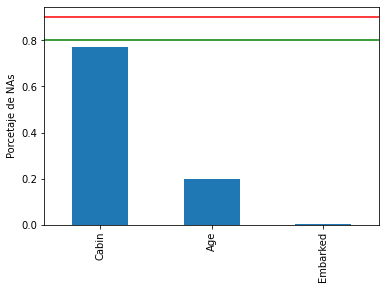

In [10]:
data[var_with_na].isnull().mean().sort_values(ascending=False).plot.bar()
plt.ylabel('Porcetaje de NAs')
plt.axhline(y=0.9, color='r')
plt.axhline(y=0.8, color='g')
plt.show()

## Impacto que tienen las variables faltantes respecto al Survived

In [11]:
def na_impact_over_target(df, Xvar, Yvar):
    df = df.copy()
    df[Yvar] = df[Yvar].astype('int')
    df[Xvar] = np.where(df[Xvar].isnull(), 1, 0)
    temp = df.groupby(Xvar)[Yvar].agg(['mean', 'std'])
    temp.plot(kind='barh', y='mean', xerr='std', legend=False, title=Yvar)
    plt.show()

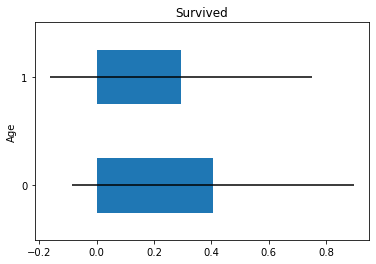

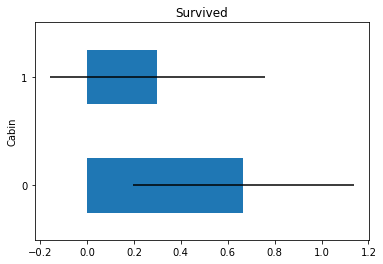

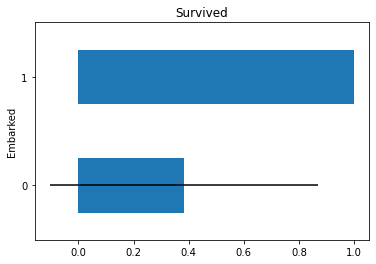

In [12]:
for var in var_with_na:
    na_impact_over_target(data, var, 'Survived')

Podemos decir que las 3 varialbles faltantes no superan un 80% del porcentaje de la data por lo que no son concideradas esenciales en el analisis de la misma y por ende se puede tomar la decisión de eliminarlas

## Transformación de Vars. Categóricas

In [13]:
data.isna().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

In [16]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
cat_vars

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

### Name

In [17]:
data['Name'].value_counts()

Dennis, Mr. Samuel                        1
Mudd, Mr. Thomas Charles                  1
Johnson, Mr. William Cahoone Jr           1
Harrison, Mr. William                     1
Yrois, Miss. Henriette ("Mrs Harbeck")    1
                                         ..
Albimona, Mr. Nassef Cassem               1
Arnold-Franchi, Mr. Josef                 1
Sloper, Mr. William Thompson              1
Torber, Mr. Ernst William                 1
Fynney, Mr. Joseph J                      1
Name: Name, Length: 891, dtype: int64

Eliminamos la variable Name ya que no tienen ninguna significanca en el data set. 

In [18]:
data.drop('Name', axis = 1, inplace=True)

### Sex

In [26]:
data['Sex'].value_counts()

0    577
1    314
Name: Sex, dtype: int64

In [27]:
data.Sex = data['Sex'].replace('male', 0)
data.Sex = data['Sex'].replace('female', 1)
data['Sex'].value_counts()

0    577
1    314
Name: Sex, dtype: int64

### Ticket

In [28]:
enc_ticket = data['Ticket'].value_counts()/data.shape[0]
enc_ticket

0.001122    0.613917
0.002245    0.210999
0.003367    0.070707
0.004489    0.049383
0.007856    0.023569
0.006734    0.020202
0.005612    0.011223
Name: Ticket, dtype: float64

In [29]:
data.Ticket = data['Ticket'].apply(lambda x : enc_ticket[x])

### Embarked

In [30]:
data['Embarked'].value_counts().sort_values(ascending=False)

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [31]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,0,22.0,1,0,0.613917,7.2500,NaN,S
1,1,1,1,38.0,1,0,0.613917,71.2833,C85,C
2,1,3,1,26.0,0,0,0.613917,7.9250,NaN,S
3,1,1,1,35.0,1,0,0.210999,53.1000,C123,S
4,0,3,0,35.0,0,0,0.613917,8.0500,NaN,S


#### Transformación Yeo-Johnson

In [32]:
import scipy.stats as stats

In [35]:
num_vars = [var for var in data.columns if(var not in cat_vars and var != 'Survived')]

In [44]:
cat_vars = [var for var in data.columns if (data[var].dtype == 'O' and var != 'Survived')]

In [37]:
discrete_vars = [var for var in num_vars if((len(data[var].unique()) <20))]
discrete_vars

['Pclass', 'SibSp', 'Parch']

In [38]:
cont_vars = [var for var in num_vars if var not in discrete_vars]

In [39]:
temp_yj = data.copy()
for var in cont_vars:
    temp_yj[var], param = stats.yeojohnson(data[var])

<function matplotlib.pyplot.show(close=None, block=None)>

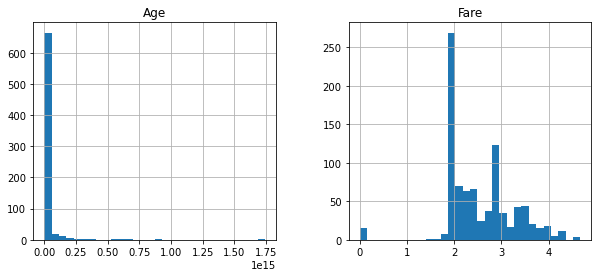

In [41]:
temp_yj[cont_vars].hist(bins=30, figsize=(10, 4))
plt.show

#### Rare Labels

In [42]:
def analyse_rare_labels(df, var, rare_perc):
    temp = df.groupby(var)['Survived'].count()/len(df)
    
    return temp[temp < rare_perc]


In [45]:
for var in cat_vars:
    print(analyse_rare_labels(data, var, 0.01))
    print()

Cabin
A10    0.001122
A14    0.001122
A16    0.001122
A19    0.001122
A20    0.001122
         ...   
F33    0.003367
F38    0.001122
F4     0.002245
G6     0.004489
T      0.001122
Name: Survived, Length: 147, dtype: float64

Series([], Name: Survived, dtype: float64)

